In [3]:
# imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import classification_report
import tensorflow.keras as keras
import PIL.Image as Image
import lime
from keras.applications import ResNet50V2 


#import tensorflow_addons as tfa
#import tensorflow_datasets as tdfs

### Function to visualize model performance

This function plots the loss and accuracy of both training and validation data across the epochs.

In [4]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


### Preprocess images

In [13]:
train_data_dir = 'data/short'

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(128, 128), batch_size=1500)

# Create the datasets
train_images, y_train = next(train_generator)


Found 1500 images belonging to 5 classes.


#### preview image labels

In [14]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

The labels are already in a format suited for modeling.

In [15]:
y_train[17]

array([0., 0., 1., 0., 0.], dtype=float32)

In [16]:
# preview shape
print(np.shape(train_images))
print(np.shape(y_train))

(1500, 128, 128, 3)
(1500, 5)


### reshape images

The images must be reshaped into a tensor before being input into a neural network model.

In [17]:
train_img_unrow = train_images.reshape(1500, -1)#.astype(uint8)

# Preview the shape of train_img_unrow
print(np.shape(train_img_unrow))

(1500, 49152)


#### normalize pixel values

In [18]:
train_img_unrow /= 255.

# Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased.

In [19]:
# make dataframe and preview
df = pd.DataFrame(y_train)
df

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0
1496,0.0,1.0,0.0,0.0,0.0
1497,0.0,1.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,1.0,0.0


In [20]:
# copy the dataframe
new=df.copy()

new


,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0
1496,0.0,1.0,0.0,0.0,0.0
1497,0.0,1.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,1.0,0.0


In [21]:
new.loc[new[4]==1,"Healthy"]=1
new.loc[new[4]==0,"Healthy"]=0
new.loc[new[4]==1,"Diseased"]=0
new.loc[new[4]==0,"Diseased"]=1
new

,0,1,2,3,4,Healthy,Diseased
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1496,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1497,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1498,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
new.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

In [23]:
new.tail(5)

,Healthy,Diseased
1495,0.0,1.0
1496,0.0,1.0
1497,0.0,1.0
1498,0.0,1.0
1499,0.0,1.0


In [24]:
# check for any null entries
new.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [25]:
new['Healthy'].sum()


300.0

In [26]:
new['Diseased'].sum()


1200.0

<AxesSubplot:>

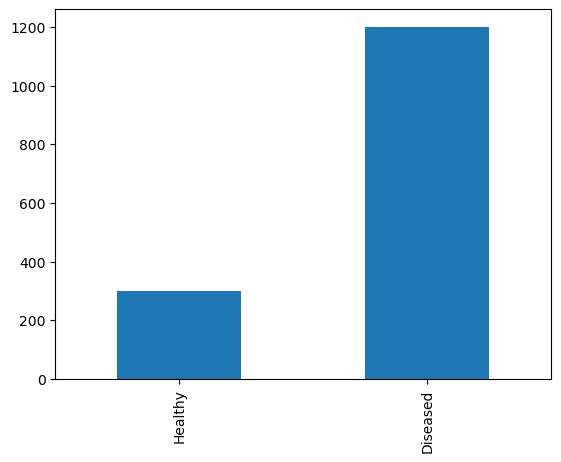

In [27]:
new.sum().plot(kind='bar')

# Modeling

This section is divided into several subsections- first, multiclass classification networks were investigated- basic neural network models, followed by CNNs and a Pretrained Resnet model. Performance was very poor overall- the best model, the pretrained ResNet, had an F-1 score of .46. In general, model scores for precision, recall, and F-1 were rarely above 0.3. Thus, all models failed to satisfactorily classify the plants into the correct one of five categories it belonged to. 

Then, a binary classification strategy was used to investigate models on classifying plants as either healthy or diseased. Rather than attempt to identify the specific disease using a neural network model, an important first step is to figure out if an image depict a plant that is healthy or diseased. Then, an expert, or perhaps more robust model, could accurately diagnose the specific disease condition. For this situation, minimizing false negatives is important, since a plant labelled as healthy when it is actually diseased would be detrimental to the customer, as their plants might go untreated would be the worst case. Thus, recall and F-1 score were used to evaluate model performance.

## Baseline Neural Network models

To begin with, basic neural network models with 1, 2, and 3 hidden dense layers were trained and evaluated. A small grid search was then performed to discover optimal parameters, followed by models with differnt regularization techniques. The basic network with 2 hidden layers, the grid search best parameter model, and the L2 model performed better than the others, with F-1 scores of .28, .29, and .22, respectively. Overall, model performance was very poor. On all the models except the three mentioned above, at least one class had an F-1 score of 0, while the others had at least one class with an F-1 score of below .12. 

#### train-test split

In [26]:
final_train, final_test, train_labels, test_labels= train_test_split(train_img_unrow, 
                                                                     y_train, 
                                                                     test_size=0.2, 
                                                                     random_state=42,
                                                                     shuffle=True)

# Binary classification Modeling

While it is ideal to be able to identify specific diseases, detecting disease is an important first step. This next section seeked to classify images into one of two categories- healthy or diseased. Again, baseline neural network models were investigated, followed by a CNN and Resnet model. Images of diseased plants consisted of 80% of the dataset. In many of the models, it appeared to indiscriminately classify plants as diseased. However, a basic network performed relatively well, and the pretrained model far outperformed all others.

#### Train-test split for binary classification networks

In [24]:
binary_train, binary_test, binary_train_labels, binary_test_labels= train_test_split(train_img_unrow, df, test_size=0.2, random_state=42,shuffle=True)


### Basic Network with 1 hidden layer

In [183]:
#instantiate model
#np.random.seed(42)
binary_model_1 = models.Sequential()
binary_model_1.add(layers.Dense(256, activation='tanh', input_shape=(49152,)))
binary_model_1.add(layers.Dense(2, activation='softmax'))

binary_model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
binary_model_1.summary()
binary_results_1 = binary_model_1.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
75/75 [==============================] - 7s 71ms/step - loss: 0.5595 - auc: 0.8044 - acc: 0.7808 - val_loss: 0.4460 - val_auc: 0.8683 - val_acc: 0.8367
Epoch 2/10
75/75 [==============================] - 4s 59ms/step - loss: 0.5106 - auc: 0.8116 - acc: 0.7900 - val_loss: 0.4328 - val_auc: 0.8759 - val_acc: 0.8367
Epoch 3/10
75/75 [==============================] - 4s 58ms/step - loss: 0.4970 - auc: 0.8315 - acc: 0.7900 - val_loss: 0.4300 - val_auc: 0.8763 - val_acc: 0.8367
Epoch 4/10
75/75 [==============================] - 5s 62ms/step - loss: 0.4905 - auc: 0.8401 - acc: 0.7883 - val_loss: 0.4262 - val_auc: 0.8836 - val_acc: 0.8367
Epoch 5/10
75/75 [==============================] - 5s 69ms/step - loss: 0.4799 - auc: 0.8493 - acc: 0.7883 - val_loss: 0.4162 - val_auc: 0.8848 - val_acc: 0.8367
Epoch 6/10
75/75 [==============================] - 4s 56ms/step - loss: 0.4744 - auc: 0.8524 - acc: 0.7950 - val_loss: 0.4389 - val_auc: 0.8853 - val_acc: 0.8367
Epoch 7/10
75/75 [====

### Evaluation

In [186]:
bin_y_pred = binary_model_1.predict(binary_test)

10/10 [==============================] - 0s 17ms/step


In [187]:
print(classification_report(binary_test_labels, np.round(bin_y_pred)))

              precision    recall  f1-score   support

           0       0.56      0.10      0.17        49
           1       0.85      0.98      0.91       251

   micro avg       0.84      0.84      0.84       300
   macro avg       0.70      0.54      0.54       300
weighted avg       0.80      0.84      0.79       300
 samples avg       0.84      0.84      0.84       300



While able to identify diseased plants rather well, this model does not accurately predict healthy plants. 

In [65]:
visualize_training_results(binary_results_1)

NameError: name 'binary_results_1' is not defined

### Network with 2 hidden layers

In [188]:
#np.random.seed(42)
binary_model_2 = models.Sequential()
binary_model_2.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
binary_model_2.add(layers.Dense(32, activation='relu'))
binary_model_2.add(layers.Dense(2, activation='sigmoid'))
binary_model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

binary_results_2 = binary_model_2.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
75/75 [==============================] - 7s 72ms/step - loss: 0.5565 - auc: 0.7907 - acc: 0.7750 - val_loss: 0.4507 - val_auc: 0.8750 - val_acc: 0.8367
Epoch 2/10
75/75 [==============================] - 5s 61ms/step - loss: 0.5209 - auc: 0.8012 - acc: 0.7917 - val_loss: 0.4330 - val_auc: 0.8740 - val_acc: 0.8367
Epoch 3/10
75/75 [==============================] - 4s 58ms/step - loss: 0.4980 - auc: 0.8301 - acc: 0.7900 - val_loss: 0.4327 - val_auc: 0.8773 - val_acc: 0.8367
Epoch 4/10
75/75 [==============================] - 4s 59ms/step - loss: 0.4910 - auc: 0.8389 - acc: 0.7908 - val_loss: 0.4330 - val_auc: 0.8818 - val_acc: 0.8367
Epoch 5/10
75/75 [==============================] - 4s 59ms/step - loss: 0.4792 - auc: 0.8511 - acc: 0.7867 - val_loss: 0.4179 - val_auc: 0.8833 - val_acc: 0.8367
Epoch 6/10
75/75 [==============================] - 5s 61ms/step - loss: 0.4763 - auc: 0.8530 - acc: 0.7950 - val_loss: 0.4422 - val_auc: 0.8844 - val_acc: 0.8367
Epoch 7/10
75/75 [====

### Evaluation

In [190]:
y_pred = binary_model_2.predict(binary_test)

10/10 [==============================] - 0s 13ms/step


In [191]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.84      1.00      0.91       251

   micro avg       0.84      0.84      0.84       300
   macro avg       0.42      0.50      0.46       300
weighted avg       0.70      0.84      0.76       300
 samples avg       0.84      0.84      0.84       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model failed to correctly identify any healthy plants- appearing to predict most as diseased. 

In [ ]:
visualize_training_results(binary_results_2)

## Binary Classification CNN model

Unlike the multiclassification CNN model, this one performed rather poorly.

#### train-test split

In [25]:
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images,
                                                                                                     df, 
                                                                                                     test_size=0.2, 
                                                                                                     random_state=42,
                                                                                                     shuffle=True)

In [207]:
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='softmax'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))

Epoch 1/10
75/75 [==============================] - 12s 139ms/step - loss: 0.5179 - auc: 0.8105 - acc: 0.7825 - val_loss: 0.4569 - val_auc: 0.8935 - val_acc: 0.8367
Epoch 2/10
75/75 [==============================] - 9s 119ms/step - loss: 0.5030 - auc: 0.8257 - acc: 0.7908 - val_loss: 0.4105 - val_auc: 0.9099 - val_acc: 0.8367
Epoch 3/10
75/75 [==============================] - 9s 122ms/step - loss: 0.4988 - auc: 0.8331 - acc: 0.7908 - val_loss: 0.4728 - val_auc: 0.8680 - val_acc: 0.8367
Epoch 4/10
75/75 [==============================] - 9s 120ms/step - loss: 0.4688 - auc: 0.8576 - acc: 0.7908 - val_loss: 0.3820 - val_auc: 0.9102 - val_acc: 0.8367
Epoch 5/10
75/75 [==============================] - 10s 128ms/step - loss: 0.4475 - auc: 0.8701 - acc: 0.7908 - val_loss: 0.3699 - val_auc: 0.9155 - val_acc: 0.8367
Epoch 6/10
75/75 [==============================] - 10s 130ms/step - loss: 0.4312 - auc: 0.8793 - acc: 0.7908 - val_loss: 0.3927 - val_auc: 0.9002 - val_acc: 0.8367
Epoch 7/10
75

### Evaluation

In [209]:
cnn_y_pred = binary_cnn_model.predict(cnn_binary_test)

10/10 [==============================] - 1s 58ms/step


In [210]:
print(classification_report(cnn_binary_test_labels, np.round(cnn_y_pred)))

              precision    recall  f1-score   support

           0       0.25      0.02      0.04        49
           1       0.84      0.99      0.91       251

   micro avg       0.83      0.83      0.83       300
   macro avg       0.54      0.50      0.47       300
weighted avg       0.74      0.83      0.76       300
 samples avg       0.83      0.83      0.83       300



Although a small improvement, like most models, this one is still failing to accurately classify healthy plants.

In [ ]:
visualize_training_results(binary_cnn_results)

### Pretrained ResNet Model

Pre-trained models are pre-built machine learning models that have already been trained on large datasets, such as ImageNet or COCO. Such datasets often contain millions of images, which allows the models to learn a wide range of features and patterns. This makes them highly accurate and effective for a variety of tasks. Moreover, training a machine learning model from scratch can be a time-consuming process and by using pre-trained models, and typically much time and resources cab be saved by starting with a model that has already been trained.

ResNet models were developed especially for image classification. ResNet-50 is a pretrained model Convolutional Neural Network(CNN) model. ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. 

Given the complexity of Resnet models compared to the previous ones, it was no surprise it performed better than all previous ones. 

In [30]:
from keras.applications import ResNet50V2

In [29]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
binary_res_model = models.Sequential()
binary_res_model.add(resnet)
binary_res_model.add(layers.Flatten())
binary_res_model.add(layers.Dense(132, activation='relu'))
binary_res_model.add(layers.Dense(2, activation='sigmoid'))

In [30]:
# freeze resnet layer and verify
resnet.trainable = False

for layer in binary_res_model.layers:
    print(layer.name, layer.trainable)
    

print(len(binary_res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [31]:
# train model
binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

#np.random.seed(42) 

binary_res_history = binary_res_model.fit(cnn_binary_train,
                    cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_binary_test, cnn_binary_test_labels),                   
                    validation_steps=10)

Epoch 1/10


27/27 [==============================] - 81s 3s/step - loss: 0.4753 - acc: 0.8325 - val_loss: 0.4490 - val_acc: 0.8200
Epoch 2/10
27/27 [==============================] - 65s 2s/step - loss: 0.3253 - acc: 0.8650 - val_loss: 0.3947 - val_acc: 0.8233
Epoch 3/10
27/27 [==============================] - 66s 2s/step - loss: 0.2531 - acc: 0.8975 - val_loss: 0.3529 - val_acc: 0.8400
Epoch 4/10
27/27 [==============================] - 68s 3s/step - loss: 0.2056 - acc: 0.9225 - val_loss: 0.3480 - val_acc: 0.8267
Epoch 5/10
27/27 [==============================] - 69s 3s/step - loss: 0.1661 - acc: 0.9458 - val_loss: 0.3263 - val_acc: 0.8633
Epoch 6/10
27/27 [==============================] - 77s 3s/step - loss: 0.1369 - acc: 0.9667 - val_loss: 0.3263 - val_acc: 0.8567
Epoch 7/10
27/27 [==============================] - 80s 3s/step - loss: 0.1138 - acc: 0.9717 - val_loss: 0.3102 - val_acc: 0.8600
Epoch 8/10
27/27 [==============================] - 79s 3s/step - loss: 0.0931 - acc: 0.

### Evaluation

In [32]:
y_pred = binary_res_model.predict(cnn_binary_test)

10/10 [==============================] - 20s 1s/step


In [33]:
print(classification_report(cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.83      0.54      0.66        72
           1       0.84      0.97      0.90       228

   micro avg       0.84      0.87      0.85       300
   macro avg       0.84      0.76      0.78       300
weighted avg       0.84      0.87      0.84       300
 samples avg       0.83      0.87      0.85       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


While there is certainly room for improvement, this model is by far the best, as it is able to identify healthy and diseased plants at a rate that could be acceptable.

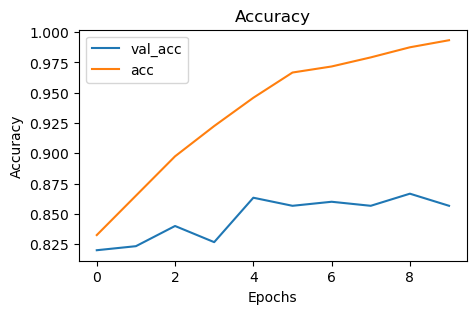

In [34]:
visualize_training_results(binary_res_history)

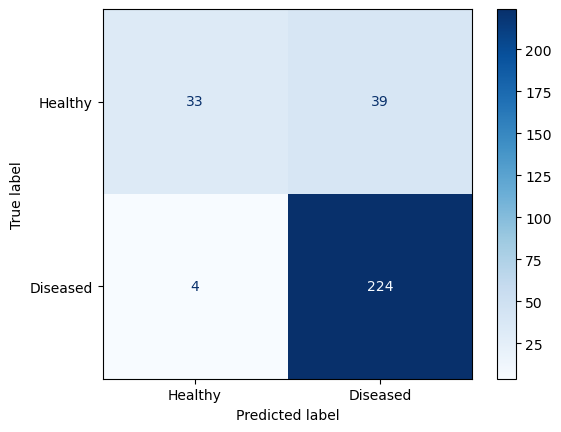

In [35]:
#confusion_matrix

cnf_matrix = confusion_matrix(cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

# Resnet model on full dataset

#### data preparation

In [3]:
full_data_dir = 'data/train'

# Get all the data in the directory data/train (790 images), and reshape them
full_train_generator = ImageDataGenerator().flow_from_directory(
        full_data_dir, 
        target_size=(128, 128), batch_size=5656)

# Create the datasets
all_train_images, all_y_train = next(full_train_generator)


Found 5656 images belonging to 5 classes.


#### preview image labels

In [4]:
# preview shape
print(np.shape(all_train_images))
print(np.shape(all_y_train))

(5656, 128, 128, 3)
(5656, 5)


### Binary labeling


In [5]:
# make dataframe and preview
all_df = pd.DataFrame(all_y_train)
all_df.loc[all_df[4]==1,"Healthy"]=1
all_df.loc[all_df[4]==0,"Healthy"]=0
all_df.loc[all_df[4]==1,"Diseased"]=0
all_df.loc[all_df[4]==0,"Diseased"]=1
all_df.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
all_df.head()

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


In [7]:
# check for any null entries
all_df.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [8]:
print(all_df['Healthy'].sum())
print(all_df['Diseased'].sum())

print(all_df['Healthy'].sum() / all_df['Diseased'].sum())

316.0
5340.0
0.05917602996254682


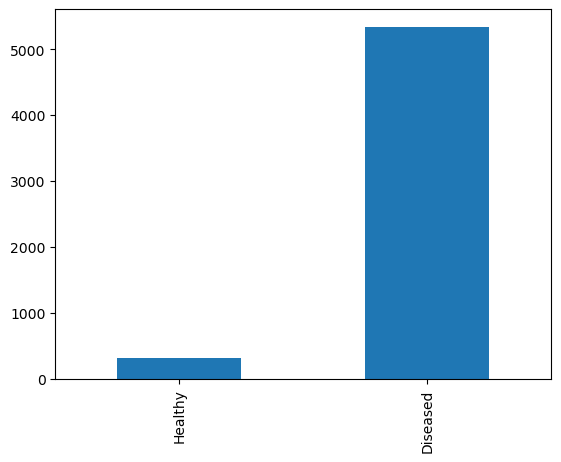

In [9]:
all_df.sum().plot(kind='bar');

#### train-test split

In [11]:
all_cnn_binary_train, all_cnn_binary_test, all_cnn_binary_train_labels, all_cnn_binary_test_labels= train_test_split(all_train_images, all_df, test_size=0.2, random_state=42,shuffle=True)


## Predict using model trained on small dataset on all data

In [71]:
y_pred = binary_res_model.predict(all_cnn_binary_test)

36/36 [==============================] - 66s 2s/step


In [72]:
print(classification_report(all_cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.95      1.00      0.97      1071

   micro avg       0.95      0.95      0.95      1132
   macro avg       0.47      0.50      0.49      1132
weighted avg       0.90      0.95      0.92      1132
 samples avg       0.95      0.95      0.95      1132



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model is inadequete for identifying healthy plants when presented with the full dataset. Thus, it will be necessary to train a new resnet model.

# Resnet model trained on full dataset

In [73]:
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [74]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 32, 32, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 32, 32, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 16, 16, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 18, 18, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 16, 16, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 16, 16, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 8, 8, 512)            66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 8, 8, 512)            0         ['max_pooling2d_4[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 8, 8, 512)            2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 10, 10, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 8, 8, 1024)           263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 8, 8, 1024)           0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 4, 4, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 4, 4, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [75]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
all_res_model = models.Sequential()
all_res_model.add(resnet)
all_res_model.add(layers.Flatten())
all_res_model.add(layers.Dense(132, activation='relu'))
all_res_model.add(layers.Dense(5, activation='sigmoid'))


In [76]:
for layer in all_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(all_res_model.trainable_weights))

resnet50v2 True
flatten_1 True
dense_2 True
dense_3 True
176


In [77]:
resnet.trainable = False

In [78]:
for layer in all_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(all_res_model.trainable_weights))

resnet50v2 False
flatten_1 True
dense_2 True
dense_3 True
4


In [79]:
all_res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [80]:
all_res_history = all_res_model.fit(all_cnn_train,
                    all_cnn_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(all_cnn_test, all_cnn_test_labels),
                    validation_steps=10)

Epoch 1/10
27/27 [==============================] - 273s 9s/step - loss: 50.3420 - acc: 0.3853 - val_loss: 45.2471 - val_acc: 0.3074
Epoch 2/10
27/27 [==============================] - 230s 9s/step - loss: 33.2439 - acc: 0.4191 - val_loss: 47.4465 - val_acc: 0.3216
Epoch 3/10
27/27 [==============================] - 189s 7s/step - loss: 30.5328 - acc: 0.4233 - val_loss: 23.5152 - val_acc: 0.4064
Epoch 4/10
27/27 [==============================] - 118s 4s/step - loss: 26.4777 - acc: 0.4443 - val_loss: 31.1398 - val_acc: 0.4929
Epoch 5/10
27/27 [==============================] - 115s 4s/step - loss: 24.4708 - acc: 0.4569 - val_loss: 24.5505 - val_acc: 0.5150
Epoch 6/10
27/27 [==============================] - 119s 4s/step - loss: 24.4672 - acc: 0.4562 - val_loss: 24.2635 - val_acc: 0.5389
Epoch 7/10
27/27 [==============================] - 116s 4s/step - loss: 22.1957 - acc: 0.4589 - val_loss: 21.2281 - val_acc: 0.3472
Epoch 8/10
27/27 [==============================] - 184s 7s/step - lo

### Evaluation

In [81]:
y_pred = all_res_model.predict(all_cnn_test)

36/36 [==============================] - 27s 692ms/step


In [82]:
print(classification_report(all_cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.42      0.09      0.15        91
           1       0.63      0.04      0.08       287
           2       0.16      0.13      0.14       150
           3       0.43      0.02      0.04       543
           4       0.00      0.00      0.00        61

   micro avg       0.28      0.05      0.08      1132
   macro avg       0.33      0.06      0.08      1132
weighted avg       0.42      0.05      0.07      1132
 samples avg       0.04      0.05      0.04      1132



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


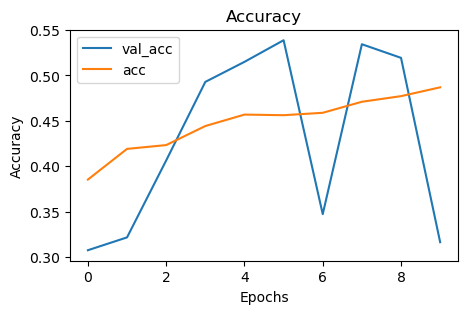

In [83]:
visualize_training_results(all_res_history)

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (1132).

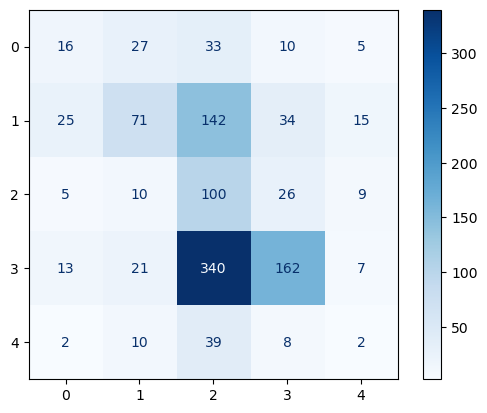

In [85]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(all_cnn_test_labels.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=all_cnn_test_labels)
disp.plot(cmap=plt.cm.Blues);

# pretrained binary model

In [12]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))
all_binary_res_model = models.Sequential()
all_binary_res_model.add(resnet)
all_binary_res_model.add(layers.Flatten())
all_binary_res_model.add(layers.Dense(132, activation='relu'))
all_binary_res_model.add(layers.Dense(2, activation='sigmoid'))

In [13]:
resnet.trainable = False

In [14]:
for layer in all_binary_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(all_binary_res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [15]:
np.random.seed(42)

all_binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])
all_binary_res_history = all_binary_res_model.fit(all_cnn_binary_train,
                    all_cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(all_cnn_binary_test, all_cnn_binary_test_labels),                   
                    validation_steps=10)

Epoch 1/10


27/27 [==============================] - 238s 8s/step - loss: 8.1307 - acc: 0.9047 - val_loss: 5.0235 - val_acc: 0.9417
Epoch 2/10
27/27 [==============================] - 227s 8s/step - loss: 4.8344 - acc: 0.9304 - val_loss: 4.2549 - val_acc: 0.9417
Epoch 3/10
27/27 [==============================] - 222s 8s/step - loss: 4.4966 - acc: 0.9224 - val_loss: 3.0947 - val_acc: 0.9302
Epoch 4/10
27/27 [==============================] - 235s 9s/step - loss: 3.7092 - acc: 0.9332 - val_loss: 4.2473 - val_acc: 0.9417
Epoch 5/10
27/27 [==============================] - 226s 8s/step - loss: 3.3666 - acc: 0.9330 - val_loss: 4.0339 - val_acc: 0.9417
Epoch 6/10
27/27 [==============================] - 229s 9s/step - loss: 2.8326 - acc: 0.9344 - val_loss: 2.3271 - val_acc: 0.8843
Epoch 7/10
27/27 [==============================] - 228s 9s/step - loss: 2.8290 - acc: 0.9381 - val_loss: 3.0782 - val_acc: 0.8295
Epoch 8/10
27/27 [==============================] - 228s 9s/step - loss: 2.5911 -

### Evaluation

In [16]:
y_pred = all_binary_res_model.predict(all_cnn_binary_test)

36/36 [==============================] - 55s 1s/step


In [17]:
print(classification_report(all_cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.30      0.12      0.17        66
           1       0.95      0.99      0.97      1066

   micro avg       0.93      0.94      0.93      1132
   macro avg       0.62      0.55      0.57      1132
weighted avg       0.91      0.94      0.92      1132
 samples avg       0.93      0.94      0.93      1132



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model performs significantly worse than the same one trained with the smaller dataset. 

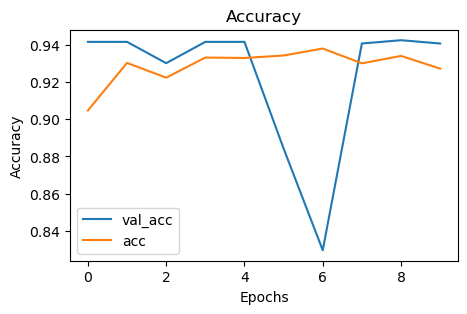

In [18]:
visualize_training_results(all_binary_res_history)

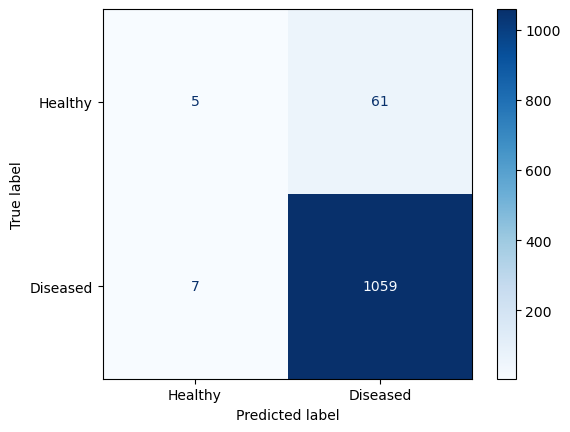

In [19]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(all_cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=all_cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

# Multiclass summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .23       | .27    | .15       |   |
| 1 hidden layer         | .29       | .30    | .28       |   |
| 2 hidden layer         | .03       | .20    | .06       |   |
| Grid Search            | .31       | .28    | .22       |   |
| L2 Regularization      | .35       | .35    | .29       |   |
| L1 Regularization      | .04       | .20    | .06       |   |
| Dropout Regularization | .03       | .20    | .06       |   |
| CNN Model              | .38       | .59    | .41       |   |
| ResNet50V2 Model       | .32       | .86    | .46       |   |
| Full ResNet50V2        | .31       | .14    | .15       |   |
|                        |           |        |           |   |

# Binary summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .70       | .54    | .54       |   |
| 1 hidden layer         | .42       | .50    | .46       |   |
| 2 hidden layer         | .41       | .50    | .45       |   |
| Grid Search            | .64       | .65    | .65       |   |
| L2 Regularization      | .61       | .62    | .61       |   |
| L1 Regularization      | .42       | .50    | .46       |   |
| Dropout Regularization | .42       | .50    | .46       |   |
| CNN Model              | .54       | .50    | .47       |   |
| ResNet50V2 Model       | .78       | .76    | .77       |   |
| Full ResNet50V2        | .55       | .60    | .57       |   |
|                        |           |        |           |   |



# Multiclass summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .23       | .27    | .15       |   |
| 1 hidden layer         | .29       | .30    | .28       |   |
| 2 hidden layer         | .03       | .20    | .06       |   |
| Grid Search            | .31       | .28    | .22       |   |
| L2 Regularization      | .35       | .35    | .29       |   |
| L1 Regularization      | .04       | .20    | .06       |   |
| Dropout Regularization | .03       | .20    | .06       |   |
| CNN Model              | .38       | .59    | .41       |   |
| ResNet50V2 Model       | .32       | .86    | .46       |   |
| Full ResNet50V2        | .31       | .14    | .15       |   |
|                        |           |        |           |   |

# Binary summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .70       | .54    | .54       |   |
| 1 hidden layer         | .42       | .50    | .46       |   |
| 2 hidden layer         | .41       | .50    | .45       |   |
| Grid Search            | .64       | .65    | .65       |   |
| L2 Regularization      | .61       | .62    | .61       |   |
| L1 Regularization      | .42       | .50    | .46       |   |
| Dropout Regularization | .42       | .50    | .46       |   |
| CNN Model              | .54       | .50    | .47       |   |
| ResNet50V2 Model       | .78       | .76    | .77       |   |
| Full ResNet50V2        | .55       | .60    | .57       |   |
|                        |           |        |           |   |

